In [ ]:
from scipy.io import loadmat
import numpy as np
from pathlib import Path

dataset_path = Path('data') / 'data.mat'
if not dataset_path.exists():
    alt = Path.cwd().parent / 'data' / 'data.mat'
    if alt.exists():
        dataset_path = alt
    else:
        raise FileNotFoundError(f"data.mat not found under {Path.cwd()} or its parent")

mat_data = loadmat(dataset_path)
print(mat_data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'hB', 'souradniceGNSS', 'souradniceX', 'souradniceY', 'souradniceZ'])


TypeError: unhashable type: 'slice'

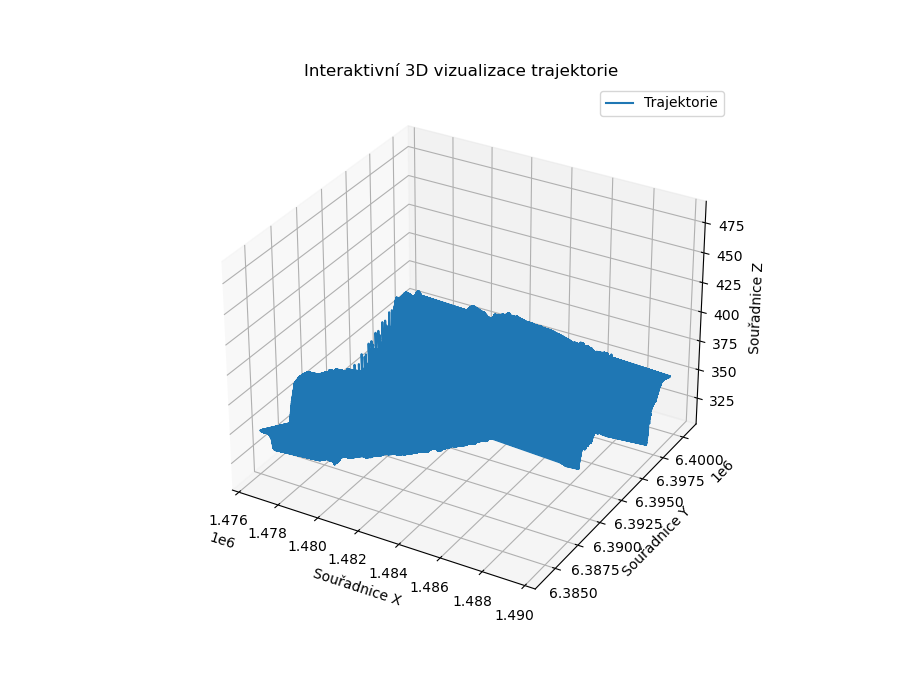

In [ ]:
import matplotlib.pyplot as plt


%matplotlib widget

try:
    souradniceX = mat_data['souradniceX'].flatten()
    souradniceY = mat_data['souradniceY'].flatten()
    souradniceZ = mat_data['souradniceZ'].flatten()
except KeyError as e:
    print(f"Chyba: Proměnná {e} nebyla nalezena v .mat souboru.")
    exit()

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(souradniceX, souradniceY, souradniceZ, label='Trajektorie')

ax.set_xlabel('Souřadnice X')
ax.set_ylabel('Souřadnice Y')
ax.set_zlabel('Souřadnice Z')
ax.legend()
ax.grid(True)

plt.show()